In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
from tqdm import tqdm

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams['axes.formatter.useoffset'] = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Meeting:
* Last time we discussed a posterior distribution I came up with on the decay rate given TTVs. It implicitly assumed known To and Po
* I'm going to present a more general posterior distribution that makes no assumptions.
* In the process I am going to:
    * Show that the previous derivation I constructed is actually the limit of the general posterior considering point function priors which pick out a known value of To and Po.
    * Show that MCMC sampling for fitting is overkill as the general distribution posterior and MAP estimate can be computed analytically.
    * Then I'm going to illustrate all of this in the context of some mock data.

#### Analytical solution

Assume a multivariate prior normal distribution on $(T_{0},P_{0},dP/dE)^{T}$:

$(T_{0},P_{0},dP/dE)^{T} \sim N(\boldsymbol{\mu_{0}}, \boldsymbol{\Sigma_{0}})$

With likelihood of data under the standard decay model:

$T(E) = T_{0} + P_{0}E + \frac{1}{2}\frac{dP}{dE}E^2$

$\{\hat{T}(E)\}_{E=0}^{E=N-1} \sim \prod_{E=0}^{E=N-1}N(\hat(T)(E)-T(E), \sigma^2)$

By multiplying the two together and completing the square, we derive an analytical posterior distribution. We can also quite easily see that the TTV-based posterior derived in notebook 3 is the same as this general posterior distribution but with point-function priors on To and Po:

$P(\frac{dP}{dE}|\{\hat{T}\}) \sim N(\text{...a long and complicated formula})$


Assuming flat priors on all parameters let's investigate how the analytic posterior performs under fake data:

E[dp/dE] = -5.403241458605045e-16
Var[dp/dE] = 7.203601512612245e-32


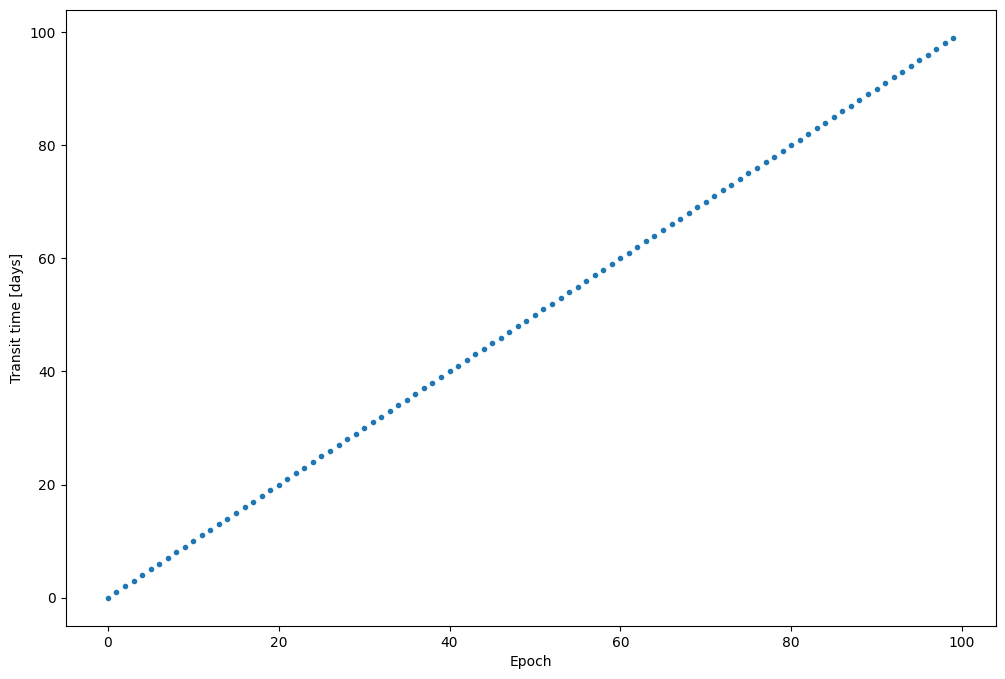

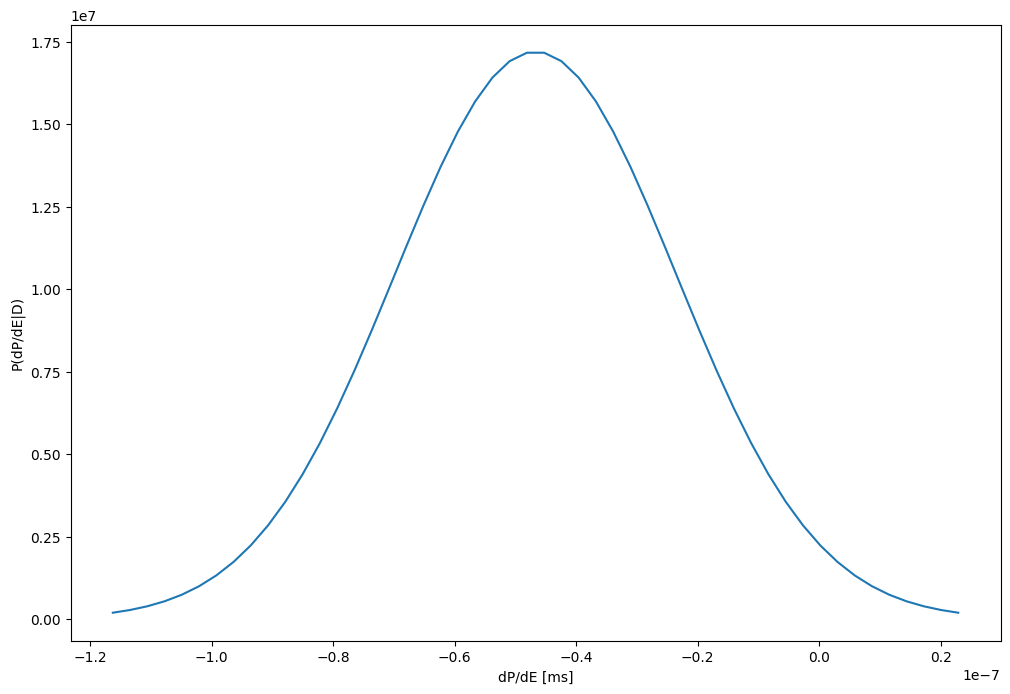

In [1759]:
# generate fake observations of a constant period model
To = 0
Po = 1  # day
dP_dE = 0

E = np.arange(100)
T = To + Po*E + 0.5*dP_dE*E**2  # mean of observations
sd = 0.000000000001 # standard deviation of observations

observations = sp.stats.multivariate_normal.rvs(mean=T, cov=sp.stats.Covariance.from_diagonal(np.full(T.shape, sd**2)))
observations = pd.Series(data=observations.flatten(), index=E)
observations.plot(style=".", xlabel="Epoch", ylabel="Transit time [days]")

# compute the analytical posterior of the observations
E = observations.index.values
T = observations.values
N = len(E)

a = E.sum()
b = (E**2).sum()
c = (E**3).sum()
d = (E**4).sum()

A = T.sum()
B = (T*E).sum()
C = (T*(E**2)).sum()

N1 = a*c-b**2
N2 = -(N*c-a*b)
N3 = N*b-a**2
DET = (d*(N*b-a**2)-b**3+2*a*b*c-N*c**2)

mu_2 = (N1*A+N2*B+N3*C)/DET
mu_dP_dE = 2 * mu_2
mu_dP_dE_ms = mu_dP_dE * (24 * 60 * 60 * 1000)

var_2 = (N*b-(a**2))*(sd**2)/DET
var_dP_dE = 4 * var_2
var_dP_dE_ms = var_dP_dE * (24 * 60 * 60 * 1000)**2

print("E[dp/dE] =", mu_dP_dE)
print("Var[dp/dE] =", var_dP_dE)
plt.show()

mu = mu_dP_dE_ms
sigma = np.sqrt(var_dP_dE_ms)
x = np.linspace(mu - 3*sigma, mu + 3*sigma)
plt.plot(x, sp.stats.norm.pdf(x, mu, sigma))
plt.xlabel("dP/dE [ms]")
plt.ylabel("P(dP/dE|D)")
plt.show()

E[dp/dE] = -0.006944750678516693
Var[dp/dE] = 3.4739590627952564e-14


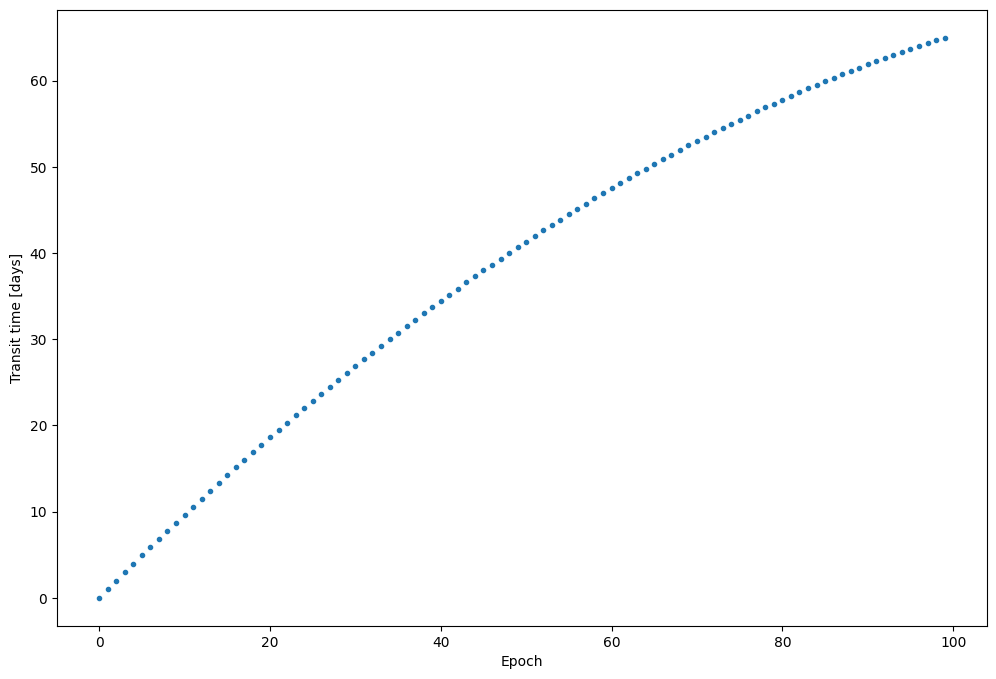

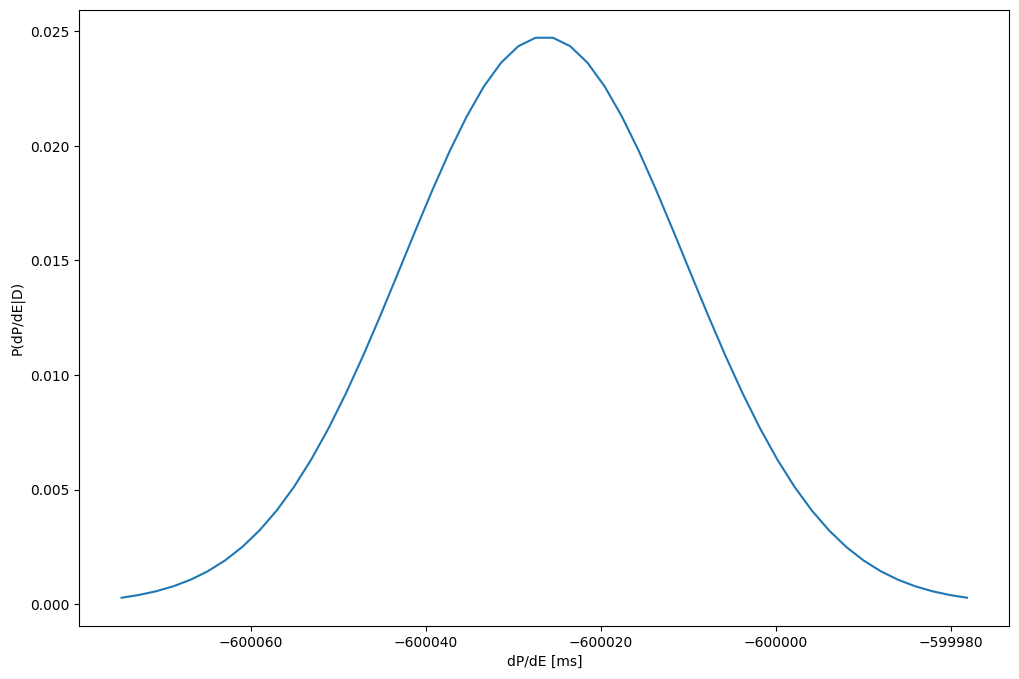

In [1710]:
# generate fake observations of a constant period model
To = 0
Po = 1  # day
dP_dE = -10/24/60  # 10 mins per orbit

E = np.arange(100)
T = To + Po*E + 0.5*dP_dE*E**2  # mean of observations
sd = 1 / 24 / 60  # standard deviation of observations

observations = sp.stats.multivariate_normal.rvs(mean=T, cov=sp.stats.Covariance.from_diagonal(np.full(T.shape, sd**2)))
observations = pd.Series(data=observations.flatten(), index=E)
observations.plot(style=".", xlabel="Epoch", ylabel="Transit time [days]")

# compute the analytical posterior of the observations
E = observations.index.values
T = observations.values
N = len(E)

a = E.sum()
b = (E**2).sum()
c = (E**3).sum()
d = (E**4).sum()

A = T.sum()
B = (T*E).sum()
C = (T*(E**2)).sum()

N1 = a*c-b**2
N2 = -(N*c-a*b)
N3 = N*b-a**2
DET = (d*(N*b-a**2)-b**3+2*a*b*c-N*c**2)

mu_2 = (N1*A+N2*B+N3*C)/DET
mu_dP_dE = 2 * mu_2
mu_dP_dE_ms = mu_dP_dE * (24 * 60 * 60 * 1000)
    
var_2 = (N*b-(a**2))*(sd**2)/DET
var_dP_dE = 4 * var_2
var_dP_dE_ms = var_dP_dE * (24 * 60 * 60 * 1000)**2

print("E[dp/dE] =", mu_dP_dE)
print("Var[dp/dE] =", var_dP_dE)
plt.show()

mu = mu_dP_dE_ms
sigma = np.sqrt(var_dP_dE_ms)
x = np.linspace(mu - 3*sigma, mu + 3*sigma)
plt.plot(x, sp.stats.norm.pdf(x, mu, sigma))
plt.xlabel("dP/dE [ms]")
plt.ylabel("P(dP/dE|D)")
plt.show()

E[dp/dE] = -7.119864089194228e-08
Var[dp/dE] = 3.4739590627952564e-14


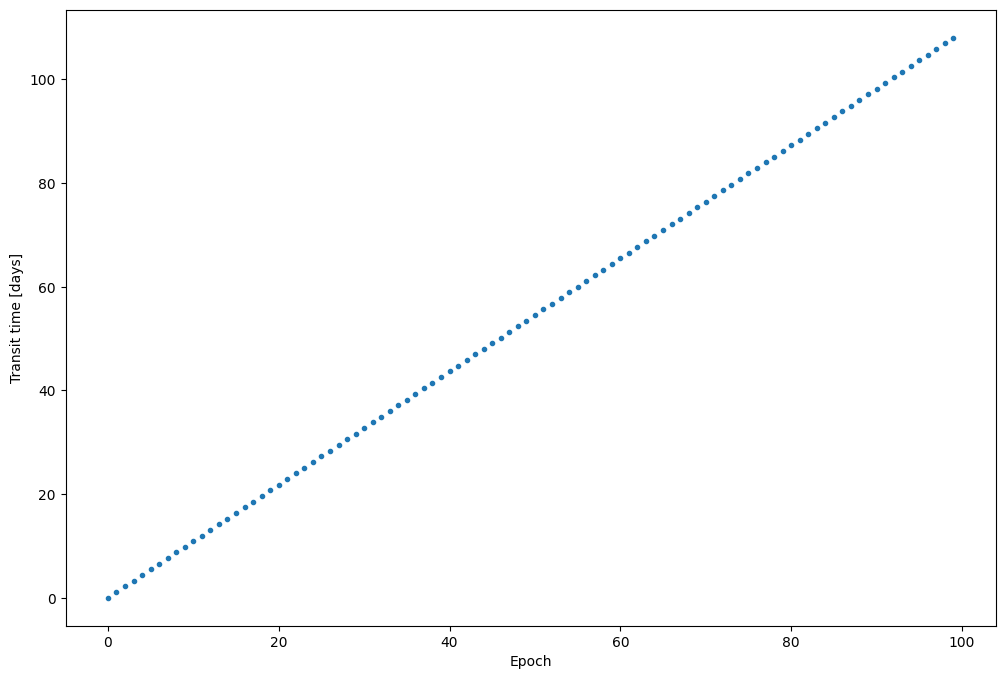

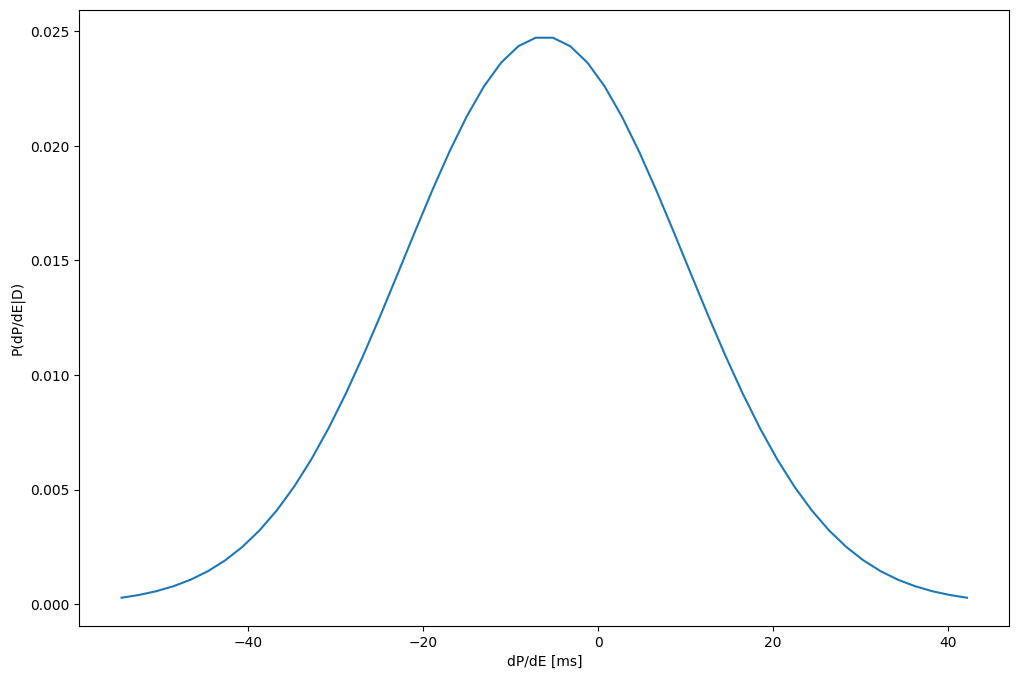

In [969]:
# a more realistic WASP-12b like decay rate
To = 0
Po = 1.091420  # day
dP_dE = -0.053703 / 1000 / 60 / 60 / 24  # days per orbit 

E = np.arange(100)
T = To + Po*E + 0.5*dP_dE*E**2  # mean of observations
sd = 1 / 24 / 60  # standard deviation of observations

observations = sp.stats.multivariate_normal.rvs(mean=T, cov=sp.stats.Covariance.from_diagonal(np.full(T.shape, sd**2)))
observations = pd.Series(data=observations.flatten(), index=E)
observations.plot(style=".", xlabel="Epoch", ylabel="Transit time [days]")

# compute the analytical posterior of the observations
E = observations.index.values
T = observations.values
N = len(E)

a = E.sum()
b = (E**2).sum()
c = (E**3).sum()
d = (E**4).sum()

A = T.sum()
B = (T*E).sum()
C = (T*(E**2)).sum()

N1 = a*c-b**2
N2 = -(N*c-a*b)
N3 = N*b-a**2
DET = (d*(N*b-a**2)-b**3+2*a*b*c-N*c**2)

mu_2 = (N1*A+N2*B+N3*C)/DET
mu_dP_dE = 2 * mu_2
mu_dP_dE_ms = mu_dP_dE * (24 * 60 * 60 * 1000)

var_2 = (N*b-(a**2))*(sd**2)/DET
var_dP_dE = 4 * var_2
var_dP_dE_ms = var_dP_dE * (24 * 60 * 60 * 1000)**2

print("E[dp/dE] =", mu_dP_dE)
print("Var[dp/dE] =", var_dP_dE)
plt.show()

mu = mu_dP_dE_ms
sigma = np.sqrt(var_dP_dE_ms)
x = np.linspace(mu - 3*sigma, mu + 3*sigma)
plt.plot(x, sp.stats.norm.pdf(x, mu, sigma))
plt.xlabel("dP/dE [ms]")
plt.ylabel("P(dP/dE|D)")
plt.show()

In [2]:
def model(E, T0, P0, dP_dE):
    return T0 + P0*E + 0.5*(dP_dE/1000/60/60/24)*E**2

In [25]:
def generate_fake_data(T0, P0, dP_dE, N, step=1, sd=60):
    # generate fake observations
    E = np.arange(0, step*N, step)
    T = model(E, T0, P0, dP_dE)
    sd = sd / 24 / 60 / 60 # standard deviation of observations in days (defaults to 60 seconds)

    observations = sp.stats.multivariate_normal.rvs(mean=T, cov=sp.stats.Covariance.from_diagonal(np.full(T.shape, sd**2)))
    observations = pd.Series(data=observations.flatten(), index=E)
    return observations

In [8]:
def fit_analytical_posterior(observations, sd):
    # compute the analytical posterior of the observations
    E = observations.index.values.astype(np.float64)
    T = observations.values.astype(np.float64)
    N = len(E)

    a = E.sum()
    b = (E**2).sum()
    c = (E**3).sum()
    d = (E**4).sum()

    A = T.sum()
    B = (T*E).sum()
    C = (T*(E**2)).sum()

    N1 = a*c-b**2
    N2 = -(N*c-a*b)
    N3 = N*b-a**2
    DET = (d*(N*b-a**2)-b**3+2*a*b*c-N*c**2)

    mu_2 = (N1*A+N2*B+N3*C)/DET
    mu_dP_dE = 2 * mu_2
    mu_dP_dE_ms = mu_dP_dE * (24 * 60 * 60 * 1000)
    
    var_2 = (N*b-(a**2))*(sd**2)/DET
    var_dP_dE = 4 * var_2
    var_dP_dE_ms = var_dP_dE * (24 * 60 * 60 * 1000)**2
    
    return mu_dP_dE_ms, var_dP_dE_ms

In [12]:
def fit_analytic_posterior_with_known_priors(observations, sd, T0, P0):
    # compute the analytical posterior of the observations
    E = observations.index.values.astype(np.float64)
    T = observations.values.astype(np.float64)
    N = len(E)

    a = E.sum()
    b = (E**2).sum()
    c = (E**3).sum()
    d = (E**4).sum()

    A = T.sum()
    B = (T*E).sum()
    C = (T*(E**2)).sum()

    mu_dP_dE = 2*(C-T0*b-P0*c)/d
    mu_dP_dE_ms = mu_dP_dE * (24 * 60 * 60 * 1000)
    
    var_dP_dE = 4*(sd**2)/d
    var_dP_dE_ms = var_dP_dE * (24 * 60 * 60 * 1000)**2
    
    return mu_dP_dE_ms, var_dP_dE_ms

##### How does number of observed transits impact posterior variance?

How does our posterior uncertainty in the decay rate change with N? 

$P(\frac{dP}{dE}|\{\hat{T}\}) \sim N(\text{...a long and complicated formula})$

And how does it compare to the known priors model?

$P(\frac{dP}{dE}|\{\hat{T}\}) \sim N(\frac{2\sum_{i=1}^{i=N-1}E_{i}^2(\hat{T}(E)-To-PoE)}{\sum_{i=1}^{i=N-1}{E_{i}^4}}, \frac{4\sigma^2}{\sum_{i=1}^{i=N-1}E_{i}^4})$

Empirically:

In [13]:
T0 = 0
P0 = 1.091420  # day
dP_dE = -0.053703  # -0.05 ms per orbit
sd = 1 / 24 / 60  # 1 min

analytical_variances = []
known_prior_variances = []
for i in tqdm(range(5, 140)):
    data = generate_fake_data(T0, P0, dP_dE, N=i)
    dP_dE_variance = fit_analytical_posterior(data, sd)[1]
    analytical_variances.append([i, dP_dE_variance])
    known_prior_variance = fit_analytic_posterior_with_known_priors(data, sd, T0, P0)[1]
    known_prior_variances.append([i, known_prior_variance])

analytical_variances = np.array(analytical_variances)
known_prior_variances = np.array(known_prior_variances)

100%|████████████████████████████████████████| 135/135 [00:00<00:00, 841.66it/s]


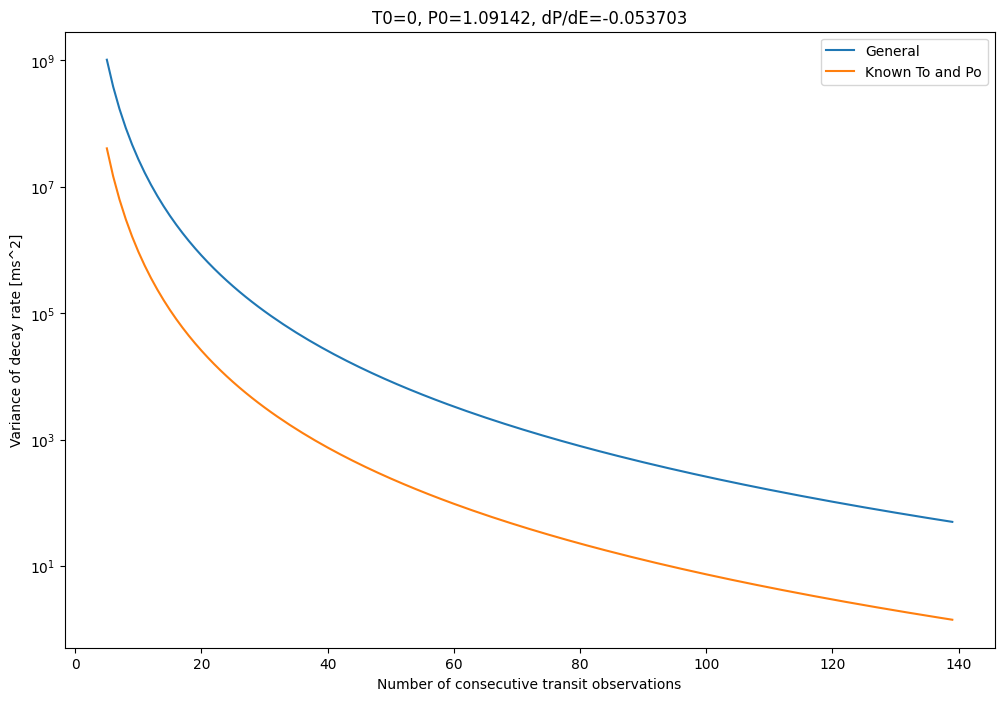

In [16]:
pd.Series(index=analytical_variances[:,0], data=analytical_variances[:,1]).plot(logy=True, xlabel="Number of consecutive transit observations", ylabel="Variance of decay rate [ms^2]", title=f"T0={T0}, P0={P0}, dP/dE={dP_dE}")
pd.Series(index=known_prior_variances[:,0], data=known_prior_variances[:,1]).plot(logy=True, xlabel="Number of consecutive transit observations", ylabel="Variance of decay rate [ms^2]", title=f"T0={T0}, P0={P0}, dP/dE={dP_dE}")
plt.legend(["General", "Known To and Po"])

We see that the initial assumption of fixed To and Po drastically underestimates the variance of the general posterior with uninformative priors.

However that is not to say the simplified model isn't helpful in some sense. For one, it is a much simpler formula with an easily invertible CDF. Second, an uninformative priod is just the other extreme. It is likely that when modelling transits other information is available in the form of RVs or some knowledge or the radius of the planet and mass of the star that lets you work out a rough period using Kepler's third law.

We can take the same CDF statistical significance approach with the general posterior, but it's a bit harder. If we marginalise out the other parameters we can find a distribution over dP/dE whose CDF is well-defined. (https://stats.stackexchange.com/questions/485821/marginalizing-multivariate-gaussian-distribution)

$P(\frac{dP}{dE}|\{\hat{T}_{i}\}_{i=1}^{i=N} \lt 0) = \frac{1}{2}[1+\mathrm{erf}(\frac{\frac{dP}{dE}-E[dp/dE]}{\sqrt{2Var[dp/dE]}})] = 0.975$

This defines the statistical signficance from which we can create a metric like in the simple TTV case, and this is the real benefit of the analytical posterior method over MCMC sampling. We can now reason intuitively about how the number and spacing of transits affects the uncertainty in the decay rate!

The only thing is the formula for E (which can be seen in the code above) is rather complex and does not lend itself to a simple formula. By making some assumptions such as consecutively observed transits it is possible we could simplify this somewhat and find the limiting behaviour for large N. As is though, it is not a simply invertible function.

Does this tend to 0? Analytically, the variance is dominated by the $\sum{E^4}$ term on the bottom, which causes the variance to tend to 0 as $E \rightarrow \infty $.

**TODO:** Expand out the term to first or second order to come up with a simple closed form formula for posterior variance in terms of N, the number of consecutively spaced transits.

100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


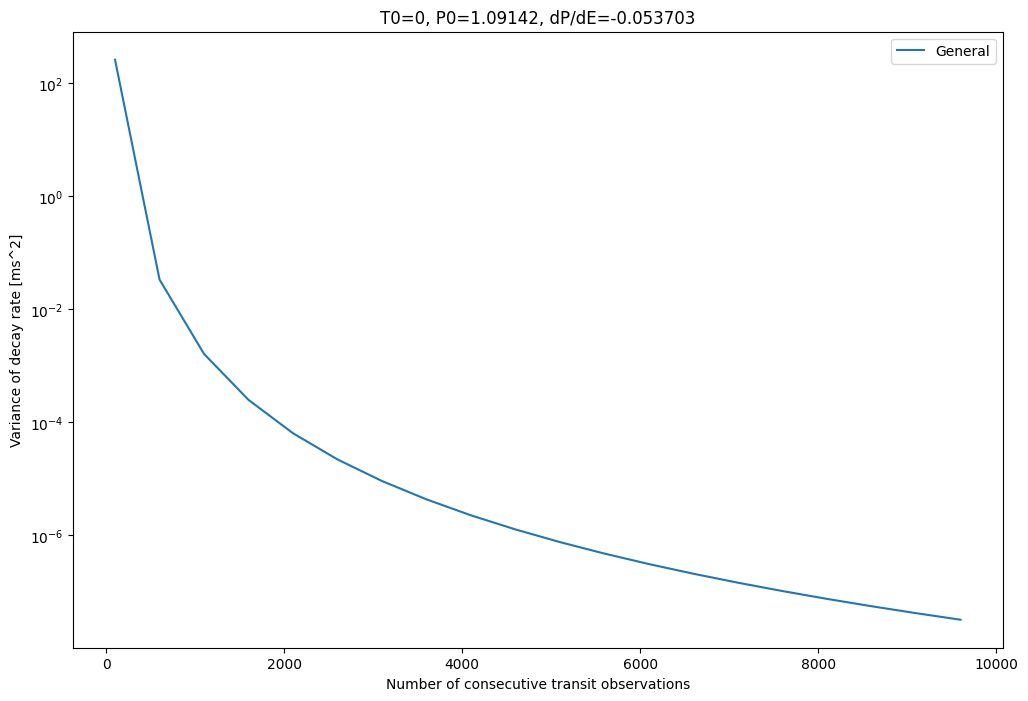

In [18]:
T0 = 0
P0 = 1.091420  # day
dP_dE = -0.053703  # -0.05 ms per orbit
sd = 1 / 24 / 60  # 1 min

analytical_variances = []
for i in tqdm(range(100, 10000, 500)):
    data = generate_fake_data(T0, P0, dP_dE, N=i)
    dP_dE_variance = fit_analytical_posterior(data, sd)[1]
    analytical_variances.append([i, dP_dE_variance])

analytical_variances = np.array(analytical_variances)

pd.Series(index=analytical_variances[:,0], data=analytical_variances[:,1]).plot(logy=True, xlabel="Number of consecutive transit observations", ylabel="Variance of decay rate [ms^2]", title=f"T0={T0}, P0={P0}, dP/dE={dP_dE}")
plt.legend(["General"])

##### How does transit spacing impact posterior variance?

In [20]:
T0 = 0
P0 = 1.091420  # day
dP_dE = -0.053703  # -0.05 ms per orbit
sd = 1 / 24 / 60  # 1 min

analytical_variances = []
for step in tqdm(range(1, 1000)):
    data = generate_fake_data(T0, P0, dP_dE, N=100, step=step)
    dP_dE_variance = fit_analytical_posterior(data, sd)[1]
    analytical_variances.append([step, dP_dE_variance])

analytical_variances = np.array(analytical_variances)

100%|███████████████████████████████████████| 999/999 [00:00<00:00, 1997.78it/s]


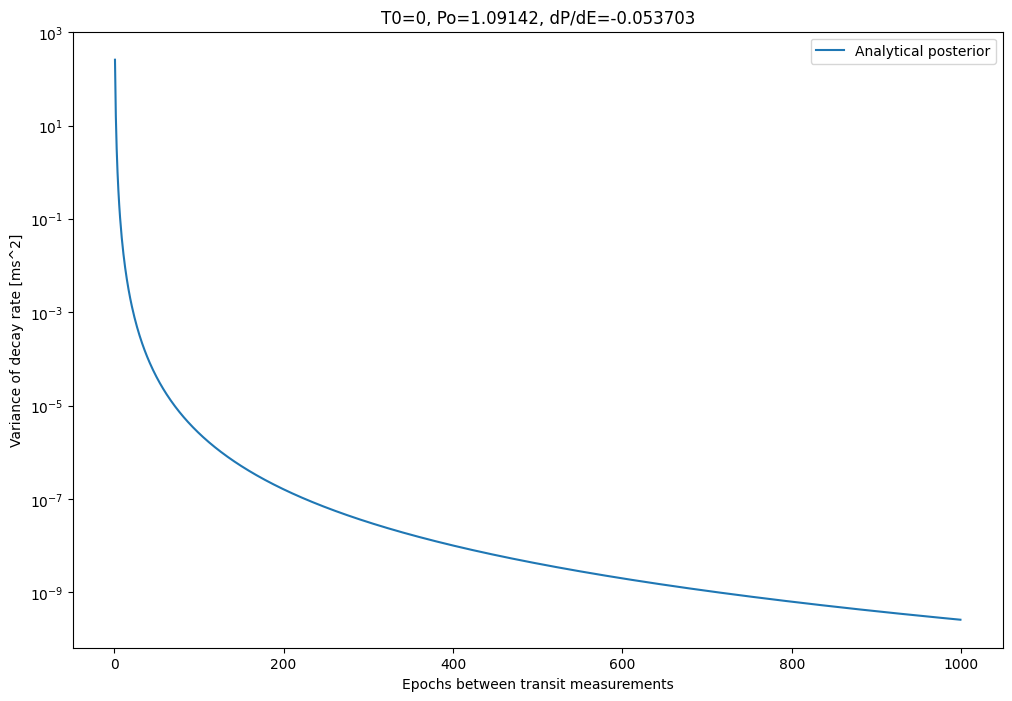

In [22]:
pd.Series(index=analytical_variances[:,0], data=analytical_variances[:,1]).plot(logy=True, xlabel="Epochs between transit measurements", ylabel="Variance of decay rate [ms^2]", title=f"T0={T0}, Po={P0}, dP/dE={dP_dE}")
plt.legend(["Analytical posterior"])

(Again we can Taylor expand to find a simple formula that describes this relationship.)

##### How does measurement uncertainty impact posterior variance?

100%|████████████████████████████████████████| 179/179 [00:00<00:00, 996.60it/s]


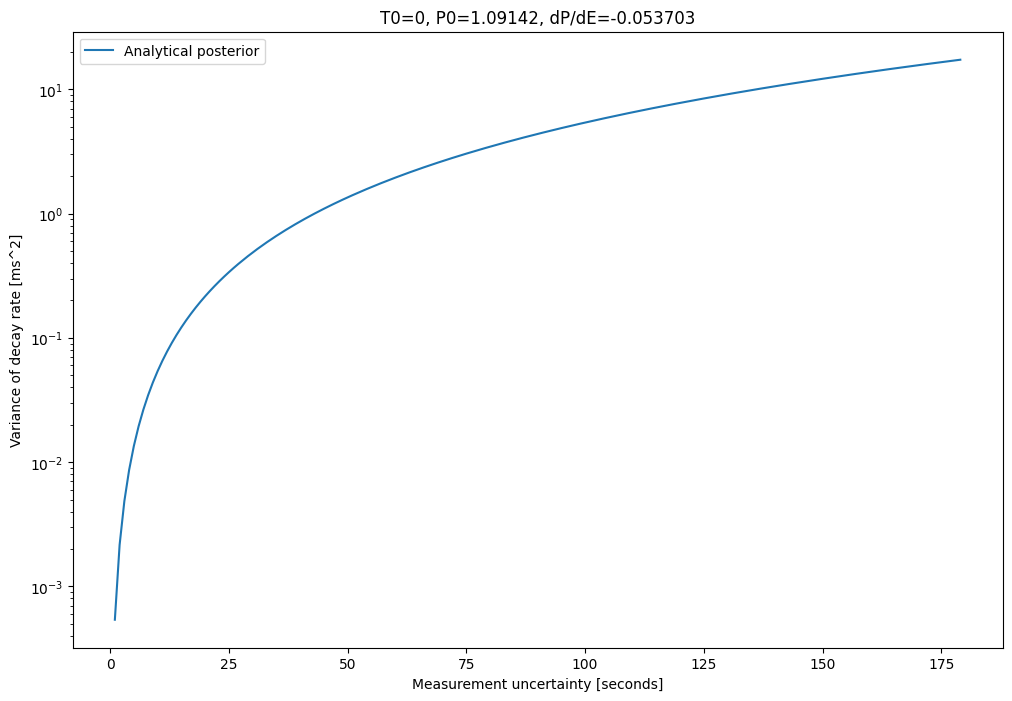

In [28]:
T0 = 0
P0 = 1.091420  # day
dP_dE = -0.053703  # -0.05 ms per orbit
sd = 1 / 24 / 60  # 1 min

analytical_variances = []
for sd in tqdm(range(1, 180)):
    data = generate_fake_data(T0, P0, dP_dE, N=100, step=step, sd=sd)
    dP_dE_variance = fit_analytical_posterior(data, sd)[1]
    analytical_variances.append([sd, dP_dE_variance])

analytical_variances = np.array(analytical_variances)
pd.Series(index=analytical_variances[:,0], data=analytical_variances[:,1]).plot(logy=True, xlabel="Measurement uncertainty [seconds]", ylabel="Variance of decay rate [ms^2]", title=f"T0={T0}, P0={P0}, dP/dE={dP_dE}")
plt.legend(["Analytical posterior"])

##### TODO: How does prior variance impact posterior variance?

A non flat/non point normal prior introduces an additional term to the square completiong of the posterior distribution. We can then solve it in the same way as before, by identifying the covariance matrix from the covariant terms and solving the resulting simultaneous equation with an algebraic calculator.

#### Numerical MCMC

In [741]:
import emcee

<AxesSubplot: xlabel='Epoch', ylabel='Transit time [days]'>

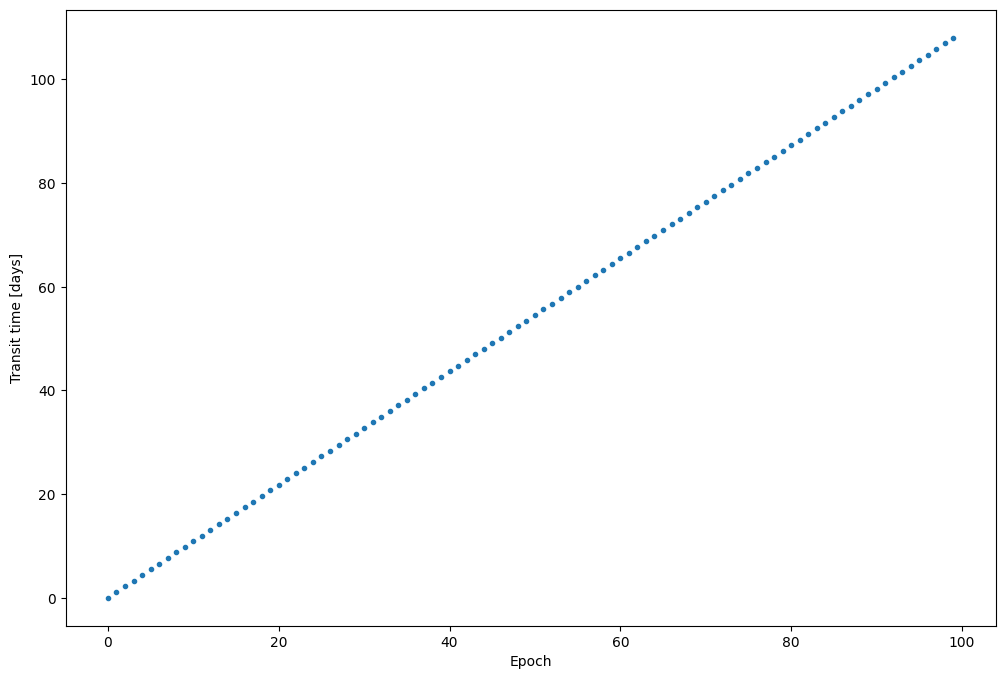

In [743]:
# generate fake observations of a constant period model
true_T0 = 0
true_P0 = 1.091420  # day
true_dP_dE = -0.053703 # ms per orbit

E = np.arange(100)
T = model(E, true_T0, true_P0, true_dP_dE)
sd = 1 / 24 / 60 / 60  # standard deviation of observations (1 min)

observations = sp.stats.multivariate_normal.rvs(mean=T, cov=sp.stats.Covariance.from_diagonal(np.full(T.shape, sd**2)))
observations = pd.Series(data=observations.flatten(), index=E)
observations.plot(style=".", xlabel="Epoch", ylabel="Transit time [days]")

With likelihood of data under the standard decay model:

$T(E) = T_{0} + P_{0}E + \frac{1}{2}\frac{dP}{dE}E^2$

$\{\hat{T}(E)\}_{E=0}^{E=N-1} \sim \prod_{E=0}^{E=N-1}N(\hat{T}(E)-T(E), \sigma^2)$



$log(P(\{\hat{T}(E)\}_{E=0}^{E=N-1})) = \prod_{E=0}^{E=N-1}N(\hat{T}(E)-T(E), \sigma^2)$

In [744]:
def log_likelihood(theta):
    T0, P0, dP_dE = theta
    
    N = len(observations.values)
    E = np.arange(N)
    mu = model(E, T0, P0, dP_dE)  # mean of observations

    log_likelihood = -(N/2 * np.log(2*sp.pi*(sd**2))) - (0.5 * np.nansum(((observations.values-mu)/sd)**2))
    return log_likelihood


def neg_log_likelihood(theta):
    return -log_likelihood(theta)

res = sp.optimize.minimize(neg_log_likelihood, (0.0, 1.0, 0.0), method="Nelder-Mead", options={'disp': True, "maxiter": 1e4})
res.x

Optimization terminated successfully.
         Current function value: -998.334772
         Iterations: 175
         Function evaluations: 328


array([ 4.46857717e-06,  1.09141992e+00, -8.41260858e-05])

$\Theta \sim \mathcal{N}((0, 1,0), \Sigma)$

A flat uniform prior with the constraint that P0 is positive:

In [745]:
def log_prior(theta):
    T0, P0, dP_dE = theta

    if P0 <= 0:
        return -np.inf  # can't have negative periods
    return 0.0

In [746]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [747]:
pos = res.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape
print("nwalkers", nwalkers, "ndim", ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 5000, progress=True);

nwalkers 32 ndim 3


100%|██████████████████████████████████████| 5000/5000 [00:12<00:00, 399.60it/s]


Text(0.5, 0, 'Step number')

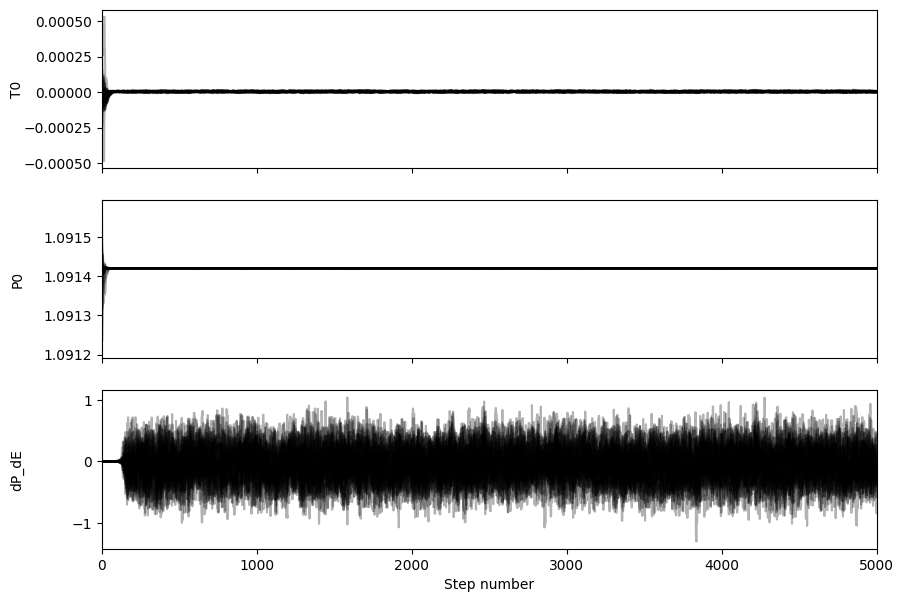

In [748]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["T0", "P0", "dP_dE"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number")

Demonstrate that the chains converge using https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr

In [749]:
tau = sampler.get_autocorr_time()
tau

array([32.7930802 , 12.96289646, 37.88096424])

In [750]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


Do the mean and variance of the posterior converge?

In [751]:
samples = sampler.get_chain(discard=0, thin=1, flat=True)[:,2]
means = []
variances = []
for i in tqdm(range(1, len(samples), 30)):
    subslice = samples[:i]
    mean = np.mean(subslice)
    means.append((i, mean))
    variance = np.var(subslice)
    variances.append((i, variance))
means = np.array(means)
variances = np.array(variances)

100%|█████████████████████████████████████| 5334/5334 [00:02<00:00, 2129.11it/s]


Text(0.5, 0, 'Step number')

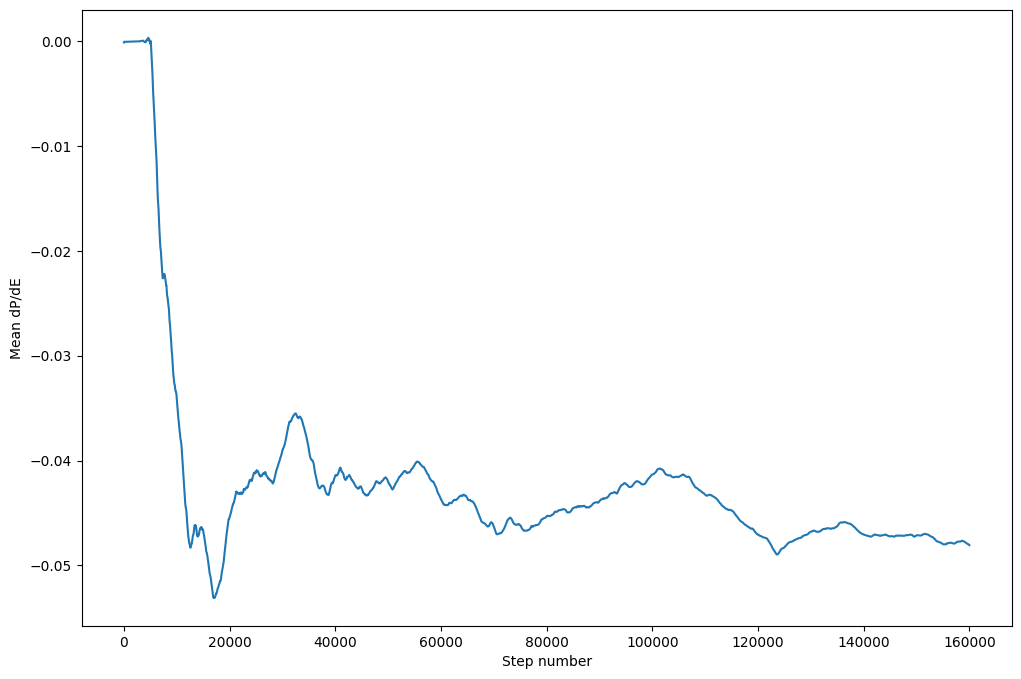

In [752]:
plt.plot(means[:,0], means[:,1])
plt.ylabel("Mean dP/dE")
plt.xlabel("Step number")

Text(0.5, 0, 'Step number')

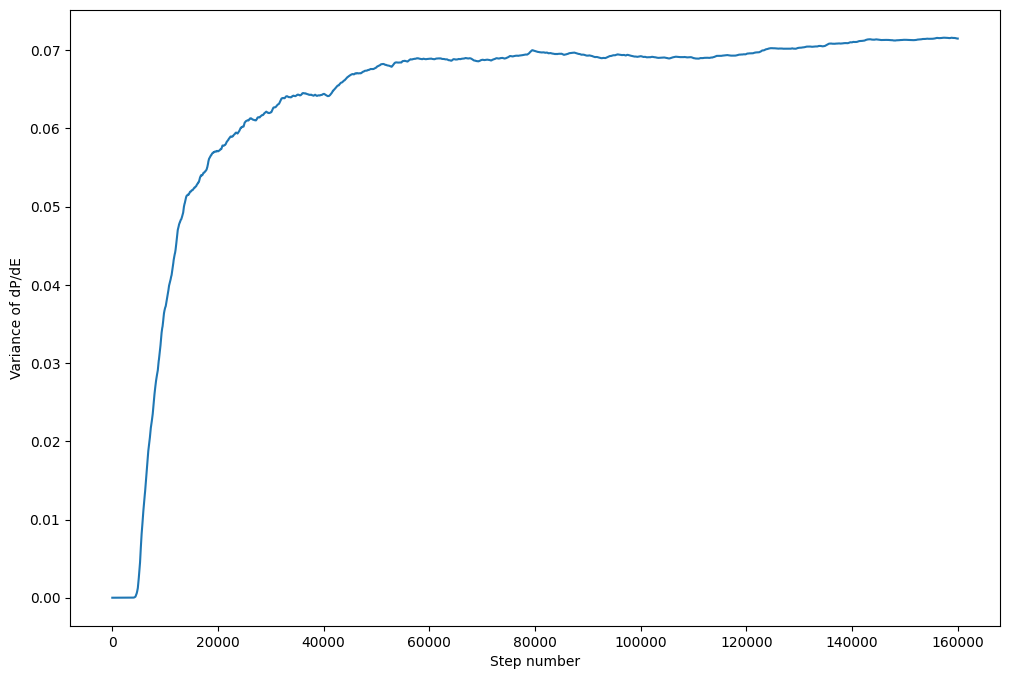

In [753]:
plt.plot(variances[:,0], variances[:,1])
plt.ylabel("Variance of dP/dE")
plt.xlabel("Step number")

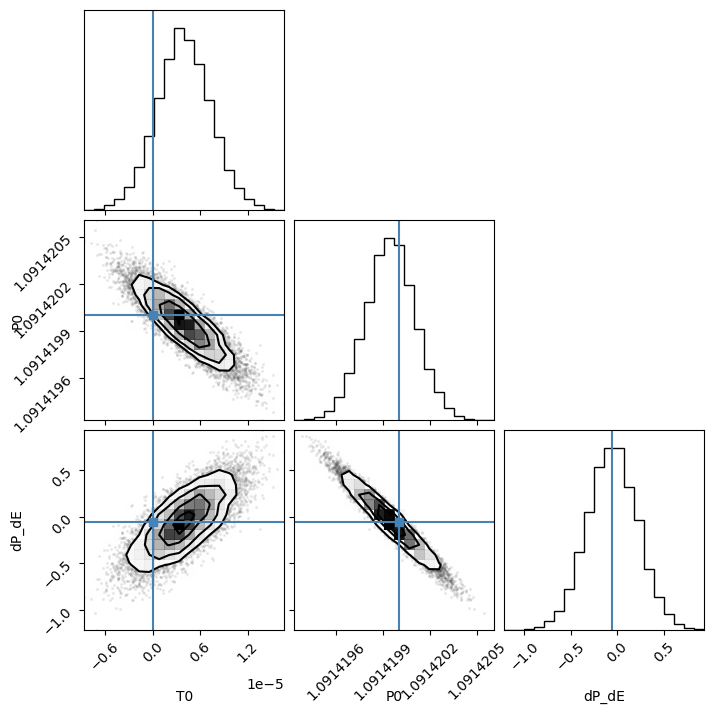

In [754]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_T0, true_P0, true_dP_dE]
)

What are the MAP values of the parameters?

In [755]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "{3} = {0:.3f}_{{-{1:.9f}}}^{{{2:.9f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [756]:
# ML values of constant model
def const_log_likelihood(theta):
    T0, P0 = theta
    
    N = len(observations.values)
    E = np.arange(N)
    mu = model(E, T0, P0, dP_dE=0)  # mean of observations

    log_likelihood = -(N/2 * np.log(2*sp.pi*(sd**2))) - (0.5 * np.nansum(((observations.values-mu)/sd)**2))
    return log_likelihood


def const_neg_log_likelihood(theta):
    return -const_log_likelihood(theta)

const_res = sp.optimize.minimize(const_neg_log_likelihood, (0.0, 1.0), method="Nelder-Mead", options={'disp': True, "maxiter": 1e4})
const_T0, const_P0 = const_res.x
const_T0, const_P0

Optimization terminated successfully.
         Current function value: -998.334755
         Iterations: 57
         Function evaluations: 104


(4.438657835211284e-06, 1.0914199160538596)

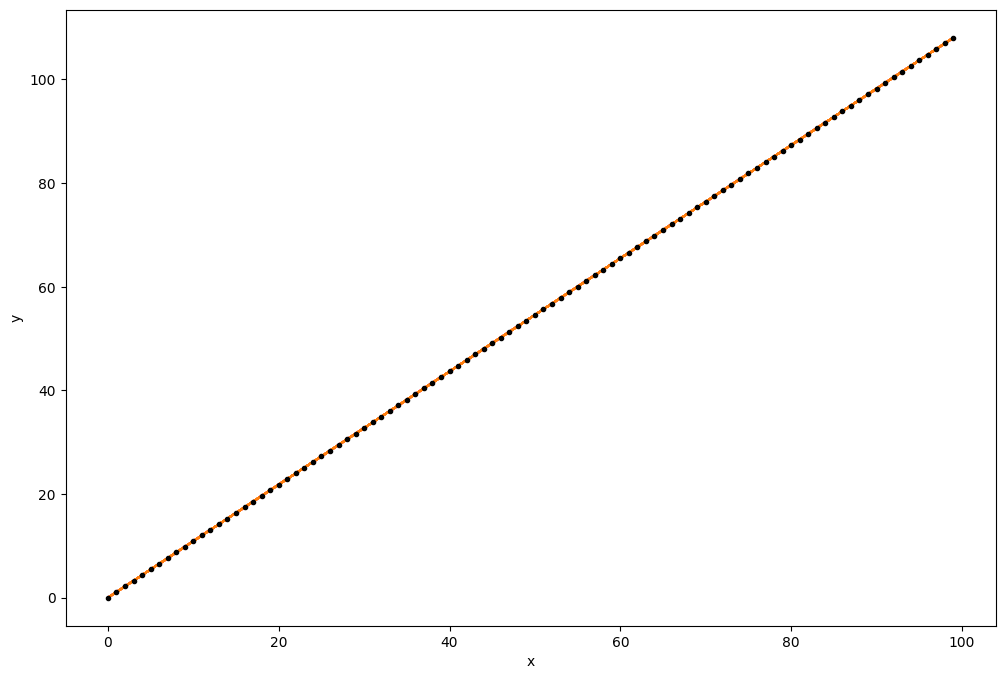

In [757]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    T0, P0, dP_dE = sample
    y = model(E, T0, P0, dP_dE)
    plt.plot(E, y, "C1", alpha=0.1)
plt.errorbar(observations.index.values, observations.values, yerr=sd, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y");
plt.show()

The above is quite hard to interpret because the fitted line appears very close to the data since the uncertainties are very small with respect to the time range over which they are measured. Instead let's try plotting timing deviation vs epoch:

In [758]:
# MAP values of decay model
T0 = np.percentile(flat_samples[:, 0], 50)
P0 = np.percentile(flat_samples[:, 1], 50)
dP_dE = np.percentile(flat_samples[:, 2], 50)
T0, P0, dP_dE

(3.8949392446873785e-06, 1.0914199472847792, -0.04801697848359799)

In [759]:
const_y = model(E, const_T0, const_P0, 0)
decay_y = model(E, T0, P0, dP_dE)

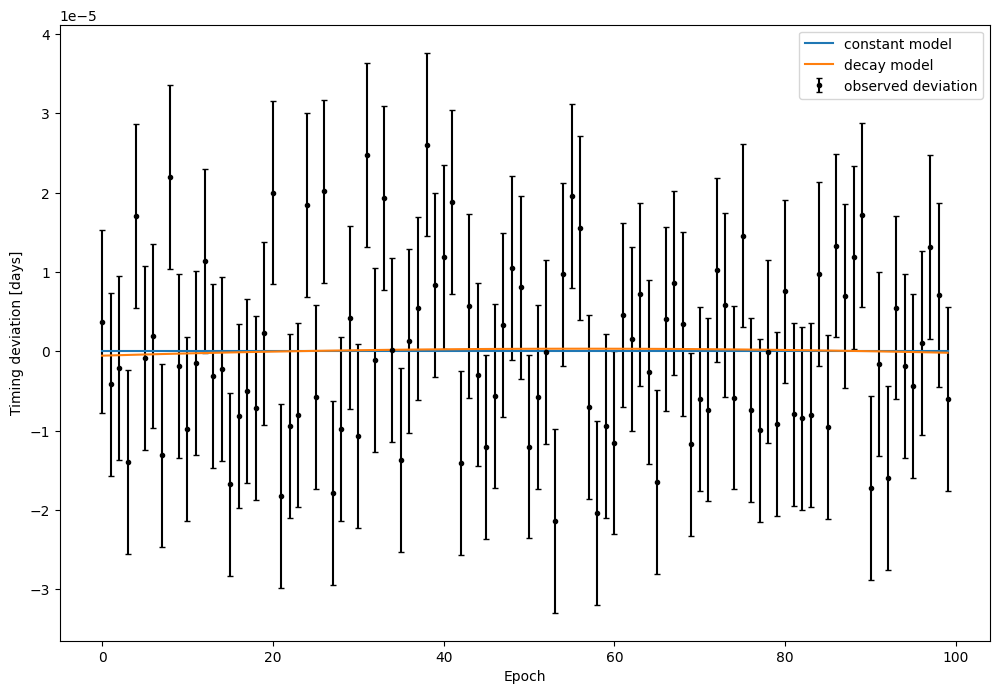

In [760]:
observed_deviation = observations.values - const_y
plt.errorbar(E, observed_deviation, yerr=sd, fmt=".k", capsize=2, label="observed deviation")

deviation = decay_y - const_y
plt.plot(E, np.full(deviation.shape, 0), label="constant model")
plt.plot(E, deviation, label="decay model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

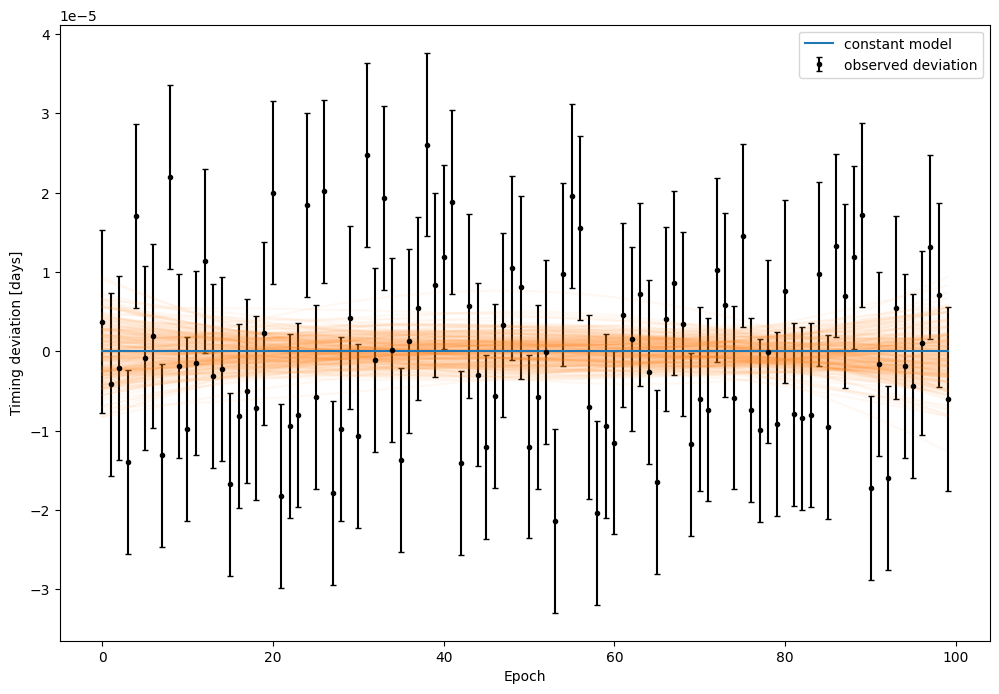

In [761]:
observed_deviation = observations.values - const_y
plt.errorbar(E, observed_deviation, yerr=sd, fmt=".k", capsize=2, label="observed deviation")

inds = np.random.randint(len(flat_samples), size=250)
for ind in inds:
    sample = flat_samples[ind]
    T0, P0, dP_dE = sample
    deviation = model(E, T0, P0, dP_dE) - const_y
    plt.plot(E, deviation, "C1", alpha=0.05)

plt.plot(E, np.full(deviation.shape, 0), label="constant model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

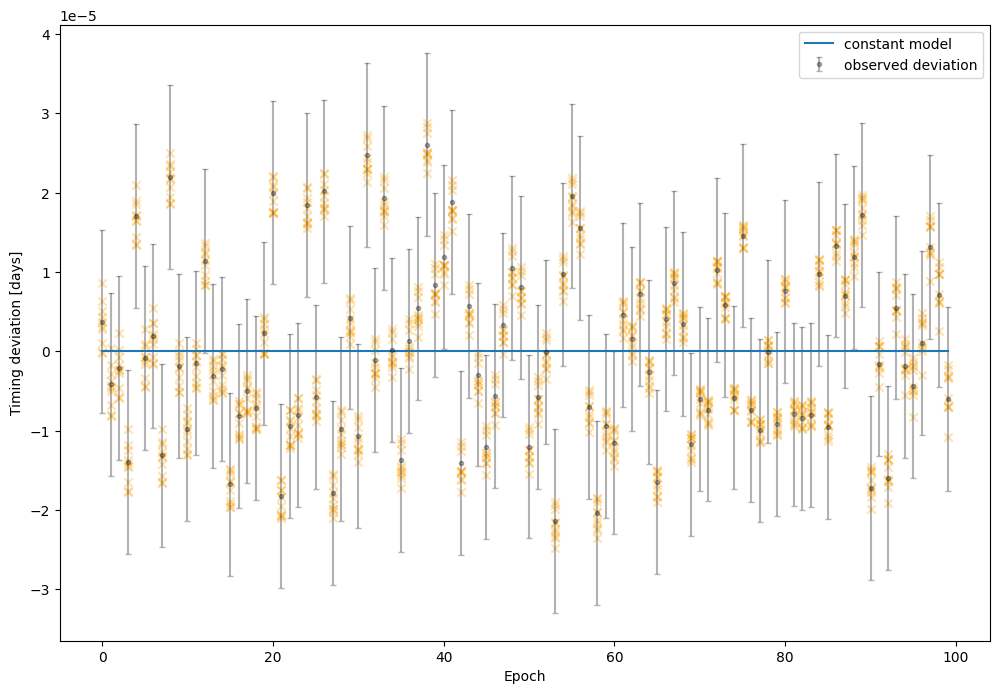

In [762]:
observed_deviation = observations.values - const_y
plt.errorbar(E, observed_deviation, yerr=sd, fmt=".k", capsize=2, label="observed deviation", alpha=0.3)

inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    T0, P0, dP_dE = sample
    y = model(E, T0, P0, dP_dE)
    observed_deviation = observations.values - y
    plt.scatter(E, observed_deviation, color="orange", alpha=0.3, marker="x")

plt.plot(E, np.full(deviation.shape, 0), label="constant model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

#### Numerical MCMC (E=1000)

<AxesSubplot: xlabel='Epoch', ylabel='Transit time [days]'>

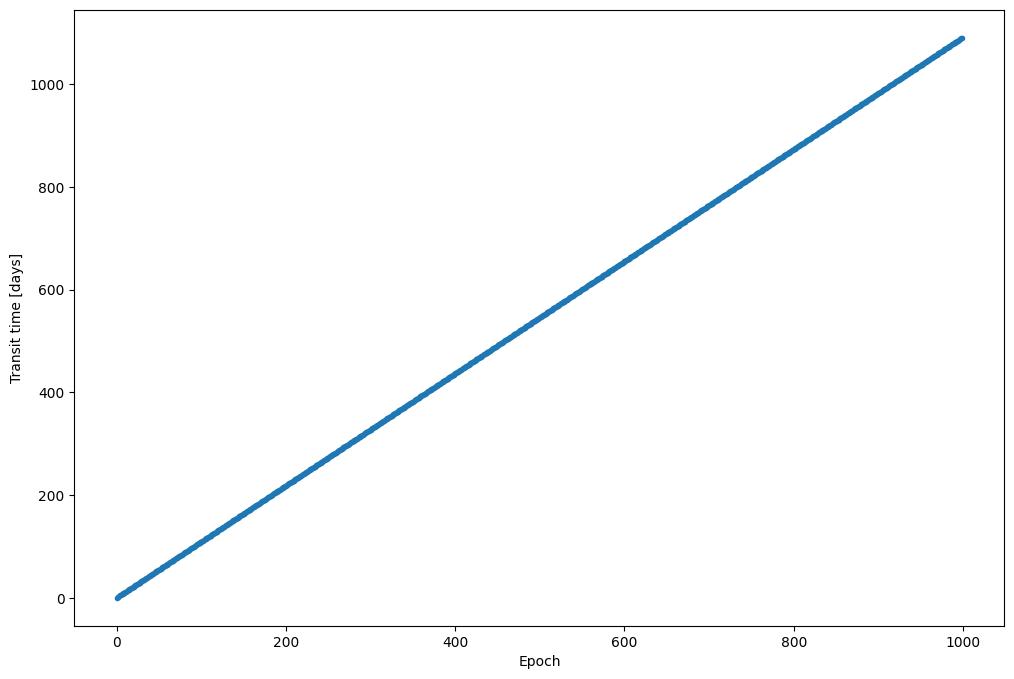

In [798]:
# generate fake observations of a constant period model
true_T0 = 0
true_P0 = 1.091420  # day
true_dP_dE = -0.053703 # ms per orbit

E = np.arange(1000)
T = model(E, true_T0, true_P0, true_dP_dE)
sd = 1 / 24 / 60 / 60  # standard deviation of observations (1 min)

observations = sp.stats.multivariate_normal.rvs(mean=T, cov=sp.stats.Covariance.from_diagonal(np.full(T.shape, sd**2)))
observations = pd.Series(data=observations.flatten(), index=E)
observations.plot(style=".", xlabel="Epoch", ylabel="Transit time [days]")

In [799]:
def log_likelihood(theta):
    T0, P0, dP_dE = theta
    
    N = len(observations.values)
    E = np.arange(N)
    mu = model(E, T0, P0, dP_dE)  # mean of observations

    log_likelihood = -(N/2 * np.log(2*sp.pi*(sd**2))) - (0.5 * np.nansum(((observations.values-mu)/sd)**2))
    return log_likelihood


def neg_log_likelihood(theta):
    return -log_likelihood(theta)

res = sp.optimize.minimize(neg_log_likelihood, (0.0, 1.0, 0.0), method="Nelder-Mead", options={'disp': True, "maxiter": 1e4})
res.x

Optimization terminated successfully.
         Current function value: -7860.177682
         Iterations: 209
         Function evaluations: 395


array([ 5.24113051e-05,  1.09141969e+00, -1.00728052e-04])

In [800]:
def log_prior(theta):
    T0, P0, dP_dE = theta

    if P0 <= 0:
        return -np.inf  # can't have negative periods
    return 0.0

In [801]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [805]:
pos = res.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape
print("nwalkers", nwalkers, "ndim", ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 10000, progress=True);

nwalkers 32 ndim 3


100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 338.79it/s]


Text(0.5, 0, 'Step number')

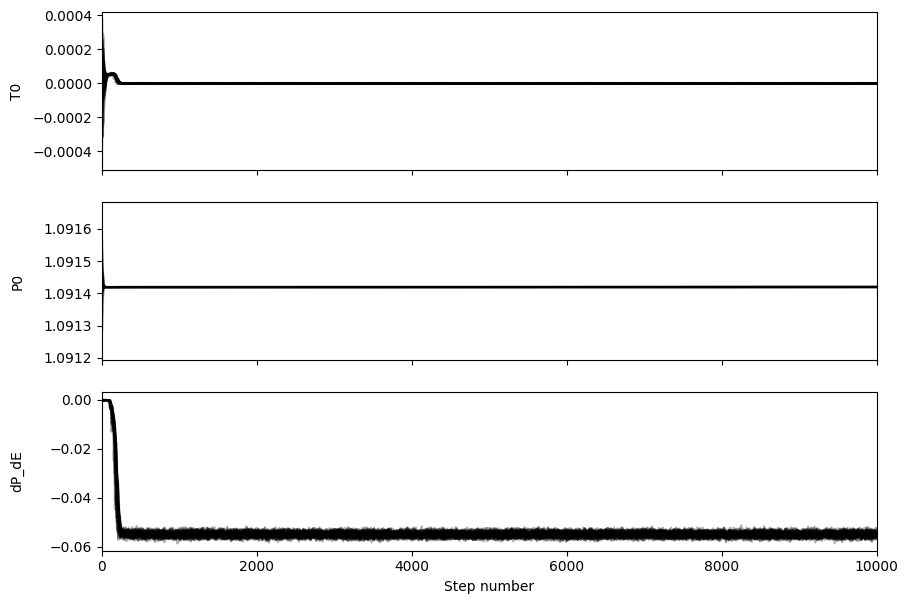

In [806]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["T0", "P0", "dP_dE"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number")

In [807]:
tau = sampler.get_autocorr_time()
tau

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [110.74270766  11.63668311 200.68217884]

In [808]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(21120, 3)


In [809]:
samples = sampler.get_chain(discard=0, thin=1, flat=True)[:,2]
means = []
variances = []
for i in tqdm(range(1, len(samples), 30)):
    subslice = samples[:i]
    mean = np.mean(subslice)
    means.append((i, mean))
    variance = np.var(subslice)
    variances.append((i, variance))
means = np.array(means)
variances = np.array(variances)

100%|████████████████████████████████████| 10667/10667 [00:10<00:00, 977.39it/s]


Text(0.5, 0, 'Step number')

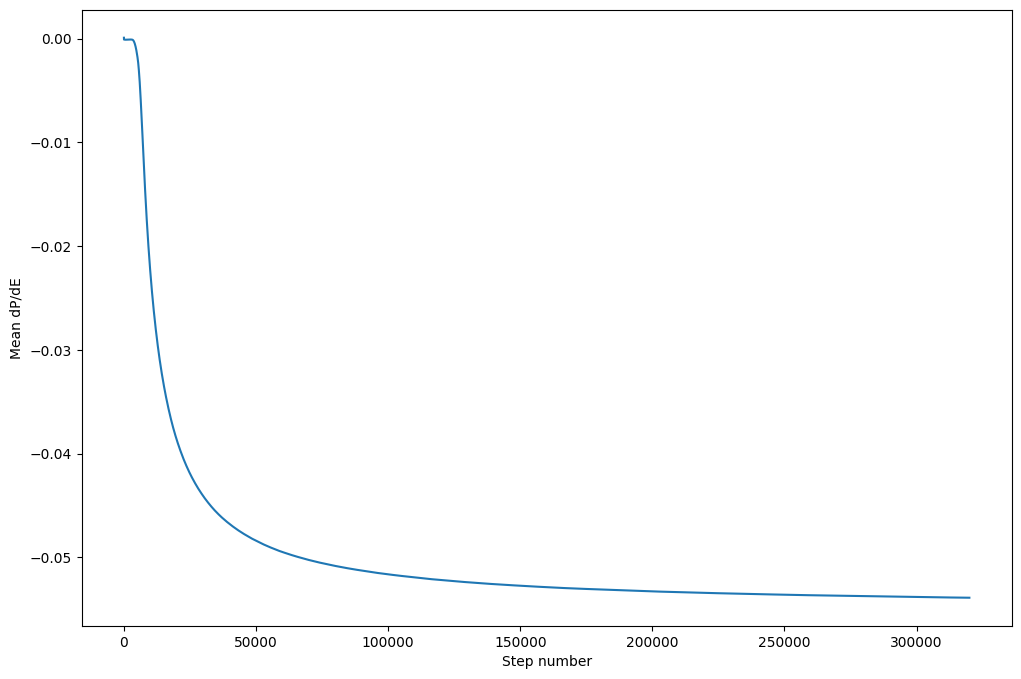

In [810]:
plt.plot(means[:,0], means[:,1])
plt.ylabel("Mean dP/dE")
plt.xlabel("Step number")

Text(0.5, 0, 'Step number')

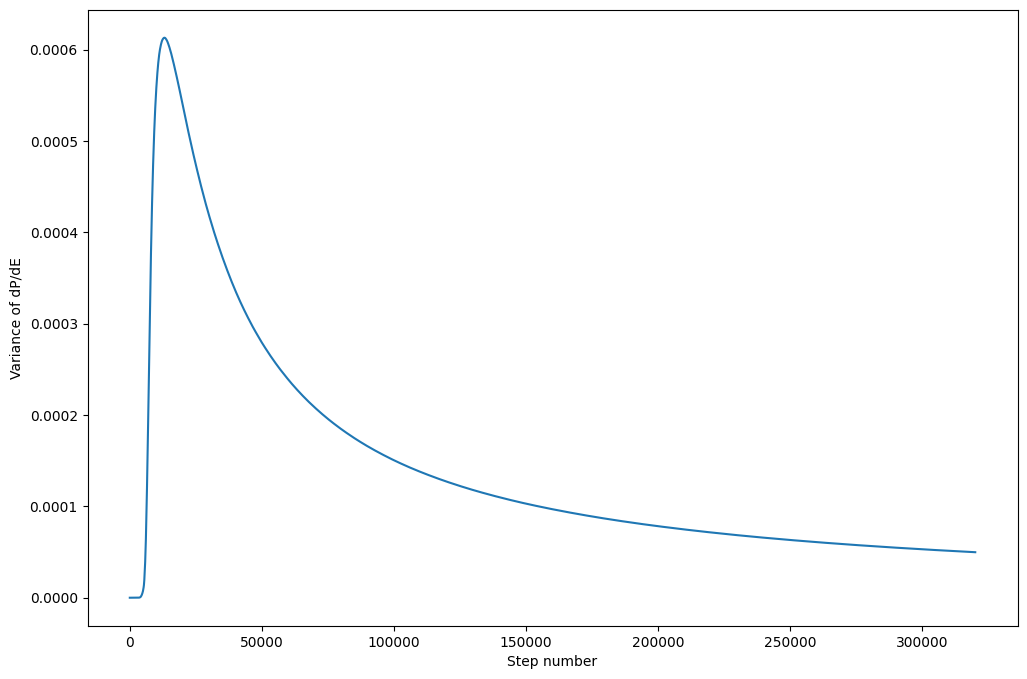

In [811]:
plt.plot(variances[:,0], variances[:,1])
plt.ylabel("Variance of dP/dE")
plt.xlabel("Step number")

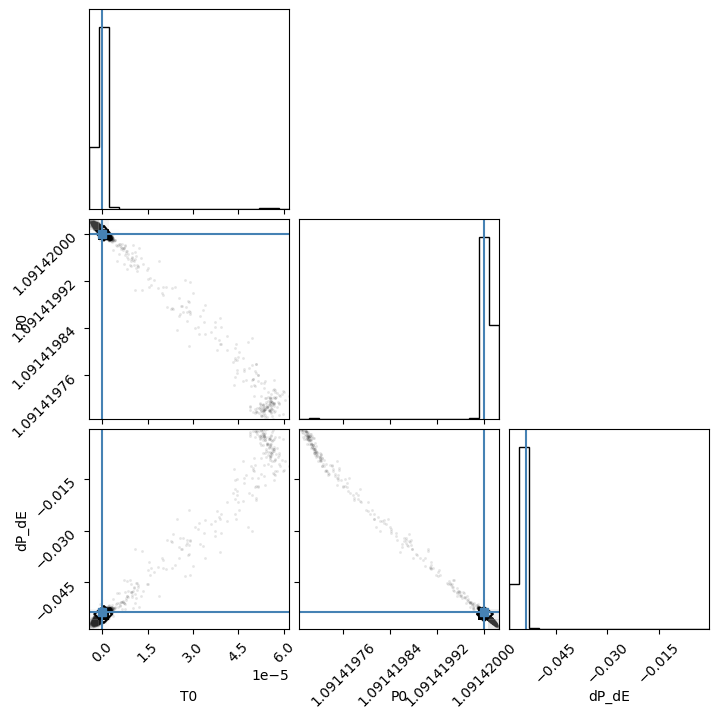

In [812]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_T0, true_P0, true_dP_dE]
)

What are the MAP values of the parameters?

In [813]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "{3} = {0:.3f}_{{-{1:.9f}}}^{{{2:.9f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [814]:
# ML values of constant model
def const_log_likelihood(theta):
    T0, P0 = theta
    
    N = len(observations.values)
    E = np.arange(N)
    mu = model(E, T0, P0, dP_dE=0)  # mean of observations

    log_likelihood = -(N/2 * np.log(2*sp.pi*(sd**2))) - (0.5 * np.nansum(((observations.values-mu)/sd)**2))
    return log_likelihood


def const_neg_log_likelihood(theta):
    return -const_log_likelihood(theta)

const_res = sp.optimize.minimize(const_neg_log_likelihood, (0.0, 1.0), method="Nelder-Mead", options={'disp': True, "maxiter": 1e4})
const_T0, const_P0 = const_res.x
const_T0, const_P0

Optimization terminated successfully.
         Current function value: -7852.504139
         Iterations: 70
         Function evaluations: 129


(5.247690989222015e-05, 1.0914196886179233)

In [816]:
# MAP values of decay model
T0 = np.percentile(flat_samples[:, 0], 50)
P0 = np.percentile(flat_samples[:, 1], 50)
dP_dE = np.percentile(flat_samples[:, 2], 50)
T0, P0, dP_dE

(-3.232553256606268e-07, 1.0914200060530046, -0.05490221977498835)

Histogram of constant period model vs decay model:

In [818]:
const_y = model(E, const_T0, const_P0, 0)
decay_y = model(E, T0, P0, dP_dE)

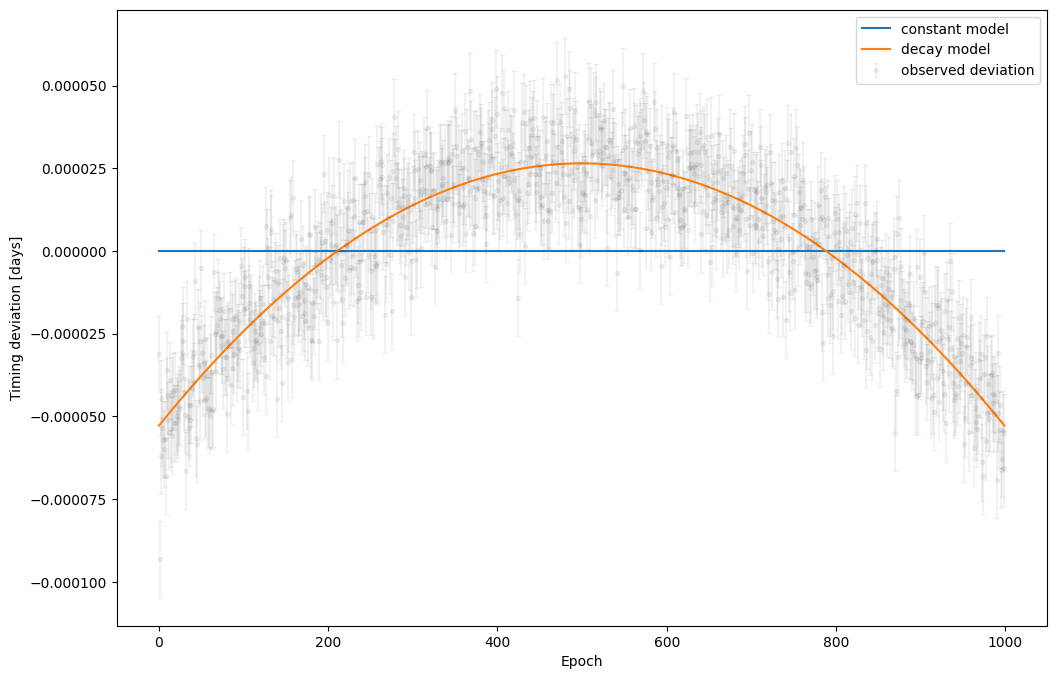

In [819]:
observed_deviation = observations.values - const_y
plt.errorbar(E, observed_deviation, yerr=sd, fmt=".k", capsize=2, label="observed deviation", alpha=0.05)

deviation = decay_y - const_y
plt.plot(E, np.full(deviation.shape, 0), label="constant model")
plt.plot(E, deviation, label="decay model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

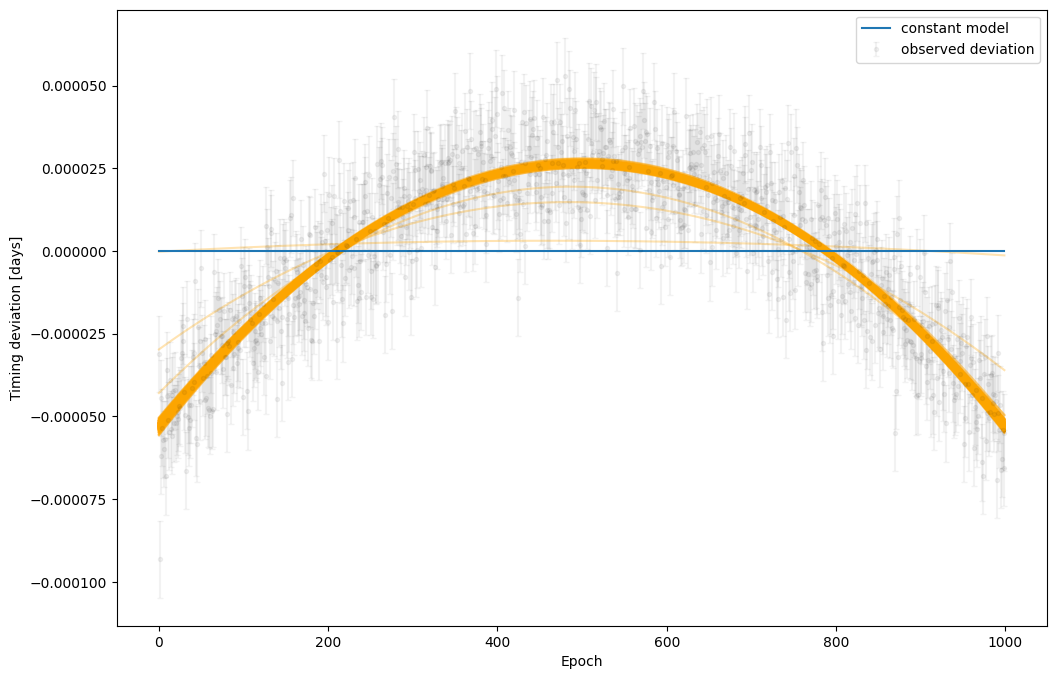

In [874]:
observed_deviation = observations.values - const_y
plt.errorbar(E, observed_deviation, yerr=sd, fmt=".k", capsize=2, label="observed deviation", alpha=0.05)

inds = np.random.randint(len(flat_samples), size=250)
for ind in inds:
    sample = flat_samples[ind]
    T0, P0, dP_dE = sample
    y = model(E, T0, P0, dP_dE)
    observed_deviation = y - const_y
    plt.plot(E, observed_deviation, color="orange", alpha=0.3)

plt.plot(E, np.full(deviation.shape, 0), label="constant model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

#### Comparison to analytical approach

How does this compare to the analytical approach? We can see from the corner plot that our posterior distribution on dP/dE is very similar to the analytical solution, BUT the MCMC takes much longer.

In [669]:
def fit_numerical_posterior(observations, burn_in=100, thin=15):
    def log_likelihood(theta):
        T0, P0, dP_dE = theta

        N = len(observations.values)
        E = np.arange(N)
        mu = model(E, T0, P0, dP_dE)  # mean of observations

        log_likelihood = -(N/2 * np.log(2*sp.pi*(sd**2))) - (0.5 * np.nansum(((observations.values-mu)/sd)**2))
        return log_likelihood


    def neg_log_likelihood(theta):
        return -log_likelihood(theta)

    def log_prior(theta):
        T0, P0, dP_dE = theta

        if P0 <= 0:
            return -np.inf  # can't have negative periods
        return 0.0

    def log_probability(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    pos = res.x + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape
    # print("nwalkers", nwalkers, "ndim", ndim)
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability
    )
    sampler.run_mcmc(pos, 2000, progress=False);
    
    flat_samples = sampler.get_chain(discard=burn_in, thin=thin, flat=True)
    dP_dE_samples = flat_samples[:, 2]
    return np.mean(dP_dE_samples), np.var(dP_dE_samples)

In [659]:
T0 = 0
P0 = 1.091420  # day
dP_dE = -0.053703  # -0.05 ms per orbit

analytical_variances = []
known_prior_variances = []
numerical_variances = []
for i in tqdm(range(5, 140, 5)):
    data = generate_fake_data(T0, P0, dP_dE, N=i)
    dP_dE_variance = fit_analytical_posterior(data)[1]
    analytical_variances.append([i, dP_dE_variance])
    known_prior_variance = fit_analytic_posterior_with_known_priors(data)[1]
    known_prior_variances.append([i, known_prior_variance])
    numerical_variance = fit_numerical_posterior(data)[1]
    numerical_variances.append([i, numerical_variance])

analytical_variances = np.array(analytical_variances)
known_prior_variances = np.array(known_prior_variances)
numerical_variances = np.array(numerical_variances)

100%|███████████████████████████████████████████| 27/27 [02:07<00:00,  4.71s/it]


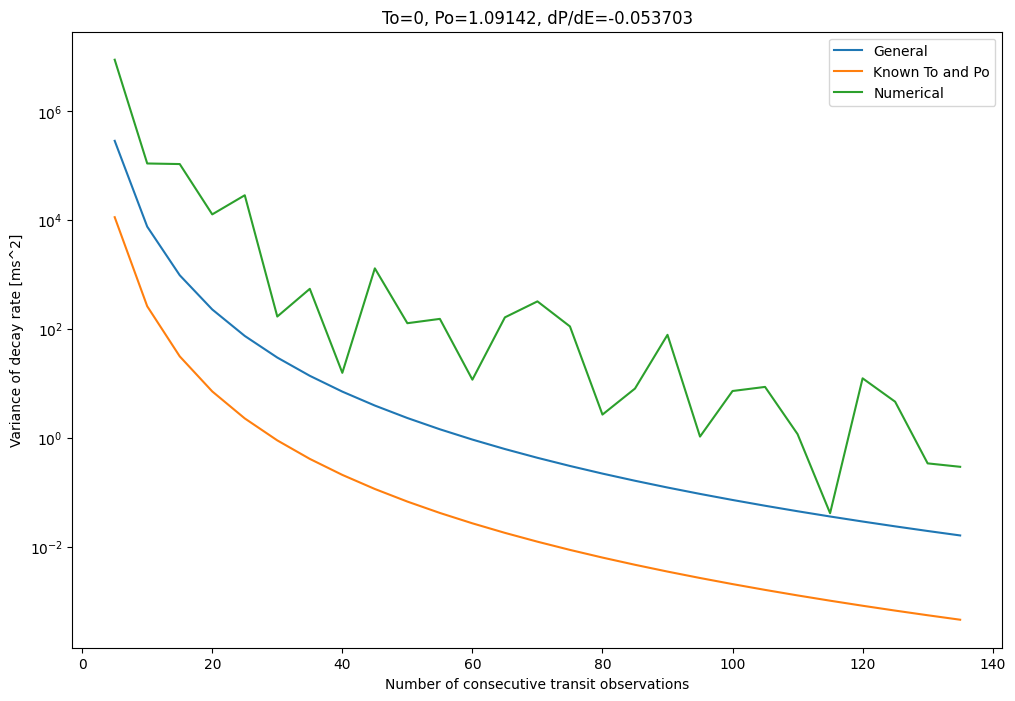

In [660]:
pd.Series(index=analytical_variances[:,0], data=analytical_variances[:,1]).plot(logy=True, xlabel="Number of consecutive transit observations", ylabel="Variance of decay rate [ms^2]", title=f"To={To}, Po={Po}, dP/dE={dP_dE}")
pd.Series(index=known_prior_variances[:,0], data=known_prior_variances[:,1]).plot(logy=True, xlabel="Number of consecutive transit observations", ylabel="Variance of decay rate [ms^2]", title=f"To={To}, Po={Po}, dP/dE={dP_dE}")
pd.Series(index=numerical_variances[:, 0], data=numerical_variances[:, 1]).plot(logy=True)
plt.legend(["General", "Known To and Po", "Numerical"])

Why is there a difference? MCMC is very sensitive to chain length and burn in, if we try a higher burn in:

In [670]:
T0 = 0
P0 = 1.091420  # day
dP_dE = -0.053703  # -0.05 ms per orbit

analytical_variances = []
known_prior_variances = []
numerical_variances = []
for i in tqdm(range(5, 140, 5)):
    data = generate_fake_data(T0, P0, dP_dE, N=i)
    dP_dE_variance = fit_analytical_posterior(data)[1]
    analytical_variances.append([i, dP_dE_variance])
    known_prior_variance = fit_analytic_posterior_with_known_priors(data)[1]
    known_prior_variances.append([i, known_prior_variance])
    numerical_variance = fit_numerical_posterior(data, burn_in=1000)[1]
    numerical_variances.append([i, numerical_variance])

analytical_variances = np.array(analytical_variances)
known_prior_variances = np.array(known_prior_variances)
numerical_variances = np.array(numerical_variances)

100%|███████████████████████████████████████████| 27/27 [01:53<00:00,  4.20s/it]


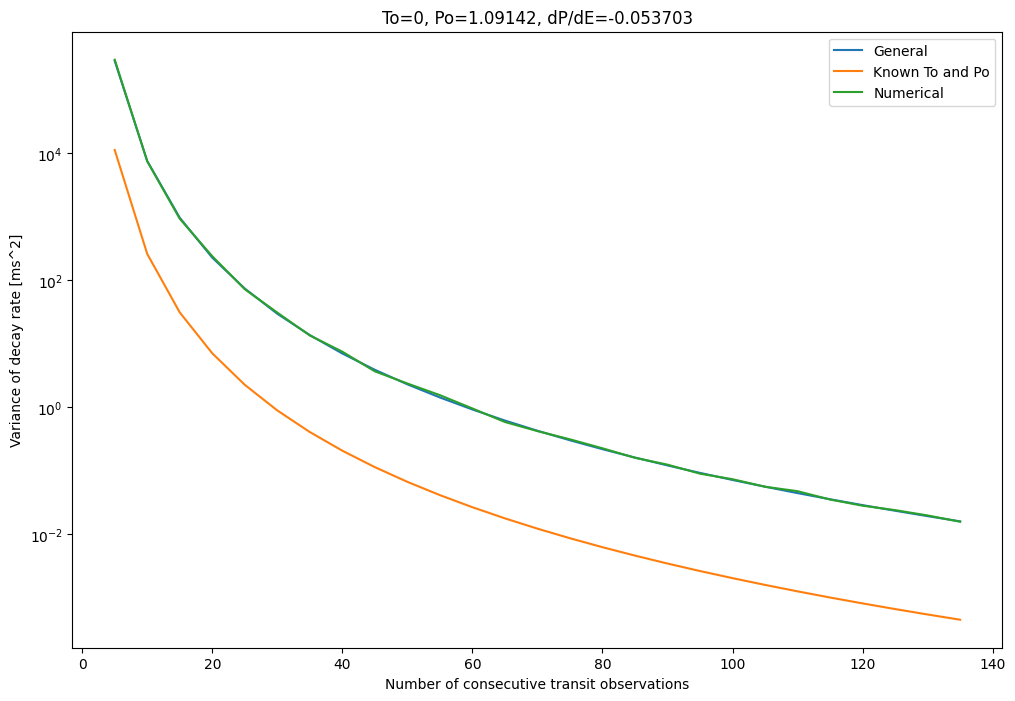

In [671]:
pd.Series(index=analytical_variances[:,0], data=analytical_variances[:,1]).plot(logy=True, xlabel="Number of consecutive transit observations", ylabel="Variance of decay rate [ms^2]", title=f"To={To}, Po={Po}, dP/dE={dP_dE}")
pd.Series(index=known_prior_variances[:,0], data=known_prior_variances[:,1]).plot(logy=True, xlabel="Number of consecutive transit observations", ylabel="Variance of decay rate [ms^2]", title=f"To={To}, Po={Po}, dP/dE={dP_dE}")
pd.Series(index=numerical_variances[:, 0], data=numerical_variances[:, 1]).plot(logy=True)
plt.legend(["General", "Known To and Po", "Numerical"])

A few important differences between the analytical solution and the numerical:
* the numerical is much slower to run, as a result I've only computed a handful of points in the above plot (30s per iteration as opposed to <1s)
* the numerical solution's convergence is sensitive to chain length and burn in

The two approaches go hand in had - numerical MCMC is useful for analysing non-standard priors for whom an analytical posterior might be hard to find, but otherwise the analytical approach is easier to reason about and much faster. This is useful when constructing metrics or analysing lots of data in bulk without worrying about MCMC convergence.